# Exploring Regularization with scikit-learn


This notebook builds a small regression problem and compares ordinary least squares with Ridge, Lasso, and ElasticNet regularization. We focus on how the regularization strength `alpha` changes the model fit, error, and coefficients.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error


### Generate random regression problem
- **make_regression** from `sklearn.datasets` can be used to generate a random regression problem.
- It has various parameteres to generate a linear regression problem.
-  

In [ ]:
X, y, true_coef = make_regression(
    n_samples=5,
    n_features=3,
    noise=0.0, # noise=0 means no noise in the data, means X @ true_coef = y
    coef=True, # coef=True means the ground-truth coefficients are returned
    random_state=0 # random_state=0 means the random number generator is seeded to 0
)

print("Feature matrix X:")
print(X)
print("\nGround-truth coefficients:")
print(true_coef)

print("\nTargets computed from X @ true_coef:")
print(X @ true_coef)  # matches y because noise=0
print("\nReturned targets y:")
print(y)

Feature matrix X:
[[ 0.97873798  0.40015721  1.76405235]
 [-0.97727788  1.86755799  2.2408932 ]
 [-0.10321885 -0.15135721  0.95008842]
 [ 0.44386323  0.12167502  0.76103773]
 [ 1.45427351  0.14404357  0.4105985 ]]

Ground-truth coefficients:
[46.14793623 79.91585642 97.86183422]

Targets computed from X @ true_coef:
[249.77904232 323.4460577   76.1182173  104.683683   118.80500893]

Returned targets y:
[249.77904232 323.4460577   76.1182173  104.683683   118.80500893]


#### How it works.

- 1. make_regression randomly draws a vector of coefficients (one weight per feature).
- 2.It generates feature rows X.
- 3.It multiplies each row by the coefficient vector to get a noiseless target.
- 4. It adds Gaussian noise to get the final y.
- 5. By default, you only receive X and y. When you pass coef=True, you also get step (1)’s coefficient vector back, so the return is (X, y, coef).

In [7]:
rng = np.random.default_rng(42)
X, y, coef = make_regression(
    n_samples=250,
    n_features=8,
    n_informative=5,
    noise=30.0,
    coef=True,
    random_state=42
)
print(X.shape)
print(y.shape)
print(coef.shape)
feature_names = [f"x{i+1}" for i in range(X.shape[1])]
print(feature_names)
X = pd.DataFrame(X, columns=feature_names)
y = pd.Series(y, name="target")
coef = pd.Series(coef, index=feature_names, name="true_coef")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)
coef


(250, 8)
(250,)
(8,)
['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8']


x1    80.823521
x2    11.099810
x3     0.000000
x4     0.000000
x5    40.710649
x6     0.000000
x7     6.600984
x8    34.882053
Name: true_coef, dtype: float64

We generated a synthetic regression problem with eight features. Five carry signal and three are purely noise. The table above shows the ground-truth coefficients used to create the data.


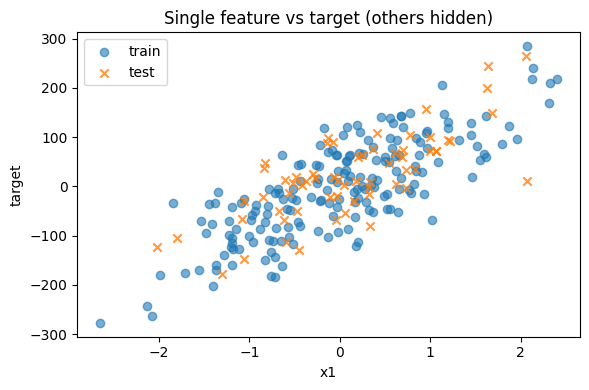

In [8]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(X_train["x1"], y_train, alpha=0.6, label="train")
ax.scatter(X_test["x1"], y_test, alpha=0.8, label="test", marker="x")
ax.set_xlabel("x1")
ax.set_ylabel("target")
ax.set_title("Single feature vs target (others hidden)")
ax.legend()
plt.tight_layout()
plt.show()


## Baseline: Ordinary Least Squares

#### Pipeline method:
- A sequence of data transformers with an optional final predictor.

- Pipeline allows you to sequentially apply a list of transformers to preprocess the data and, if desired, conclude the sequence with a final predictor for predictive modeling.

- Intermediate steps of the pipeline must be transformers, that is, they must implement fit and transform methods. The final estimator only needs to implement fit. The transformers in the pipeline can be cached using memory argument.



In [17]:
ols = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])
ols.fit(X_train, y_train)
y_pred_train = ols.predict(X_train)
y_pred_test = ols.predict(X_test)
ols_results = {
    "train_mse": mean_squared_error(y_train, y_pred_train),
    "test_mse": mean_squared_error(y_test, y_pred_test),
    "coefficients": pd.Series(
        ols.named_steps["model"].coef_, index=feature_names, name="ols_coef"
    )
}
pd.Series({"train_mse": ols_results["train_mse"], "test_mse": ols_results["test_mse"]})
print(ols["model"])
params = ols.get_params()
print(params)                    # prints every parameter with its value
print(params.keys())             # just the parameter names
print(ols.get_params(deep=True))  # only top-level (no nested model/scaler params)


LinearRegression()
{'memory': None, 'steps': [('scaler', StandardScaler()), ('model', LinearRegression())], 'verbose': False, 'scaler': StandardScaler(), 'model': LinearRegression(), 'scaler__copy': True, 'scaler__with_mean': True, 'scaler__with_std': True, 'model__copy_X': True, 'model__fit_intercept': True, 'model__n_jobs': None, 'model__positive': False}
dict_keys(['memory', 'steps', 'verbose', 'scaler', 'model', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'model__copy_X', 'model__fit_intercept', 'model__n_jobs', 'model__positive'])
{'memory': None, 'steps': [('scaler', StandardScaler()), ('model', LinearRegression())], 'verbose': False, 'scaler': StandardScaler(), 'model': LinearRegression(), 'scaler__copy': True, 'scaler__with_mean': True, 'scaler__with_std': True, 'model__copy_X': True, 'model__fit_intercept': True, 'model__n_jobs': None, 'model__positive': False}


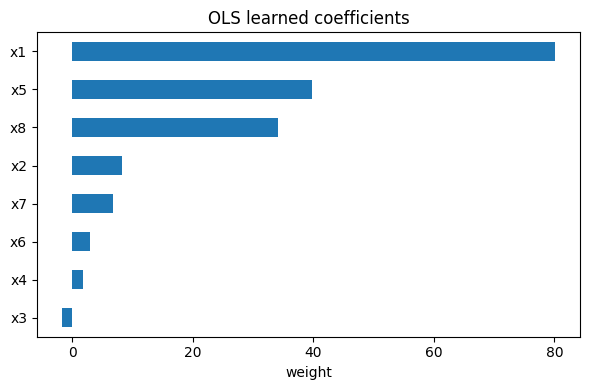

In [18]:
ols_results["coefficients"].sort_values().plot(kind="barh", figsize=(6, 4))
plt.title("OLS learned coefficients")
plt.xlabel("weight")
plt.tight_layout()
plt.show()


## Regularized models


In [ ]:
def evaluate_model(model_cls, alphas, **kwargs):
    rows = []
    coef_mat = []
    for alpha in alphas:
        model = Pipeline([
            ("scaler", StandardScaler(with_mean=True, with_std=True)),
            ("model", model_cls(alpha=alpha, **kwargs))
        ])
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rows.append({ # Keep the test MSE for each alpha
            "alpha": alpha,
            "test_mse": mean_squared_error(y_test, y_pred)
        })
        coef_mat.append(model.named_steps["model"].coef_)
    scores = pd.DataFrame(rows) # create a dataframe with the test MSE for each alpha. 
    coefs = pd.DataFrame(coef_mat, columns=feature_names) # create a dataframe with the coefficients for each alpha. 
    coefs["alpha"] = alphas
    return scores, coefs.set_index("alpha")


In [27]:
alphas = np.logspace(-3, 2, 12)
ridge_scores, ridge_coefs = evaluate_model(Ridge, alphas)
ridge_scores


,alpha,test_mse
0,0.001000,746.004173
1,0.002848,745.991956
2,0.008111,745.957174
3,0.023101,745.858210
4,0.065793,745.577146
5,0.187382,744.783059
6,0.533670,742.573022
7,1.519911,736.689818
8,4.328761,723.111463
9,12.328467,706.964902


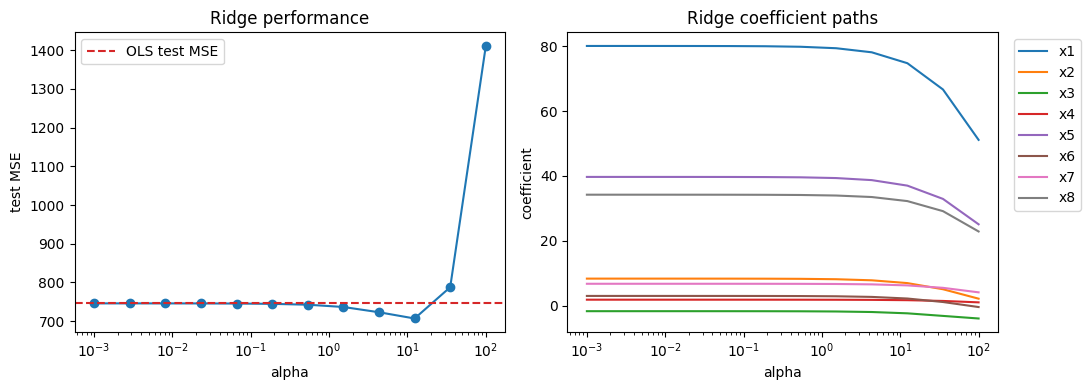

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(11, 4))
axes[0].plot(ridge_scores["alpha"], ridge_scores["test_mse"], marker="o")
axes[0].axhline(ols_results["test_mse"], color="tab:red", linestyle="--", label="OLS test MSE")
axes[0].set_xscale("log")
axes[0].set_xlabel("alpha")
axes[0].set_ylabel("test MSE")
axes[0].set_title("Ridge performance")
axes[0].legend()
for feature in feature_names:
    axes[1].plot(ridge_coefs.index, ridge_coefs[feature], label=feature)
axes[1].set_xscale("log")
axes[1].set_xlabel("alpha")
axes[1].set_ylabel("coefficient")
axes[1].set_title("Ridge coefficient paths")
axes[1].legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [22]:
lasso_scores, lasso_coefs = evaluate_model(Lasso, alphas, max_iter=5000)
lasso_scores


,alpha,test_mse
0,0.001000,745.984895
1,0.002848,745.937626
2,0.008111,745.803315
3,0.023101,745.423323
4,0.065793,744.361634
5,0.187382,741.504518
6,0.533670,734.718808
7,1.519911,726.354938
8,4.328761,781.889611
9,12.328467,1134.323399


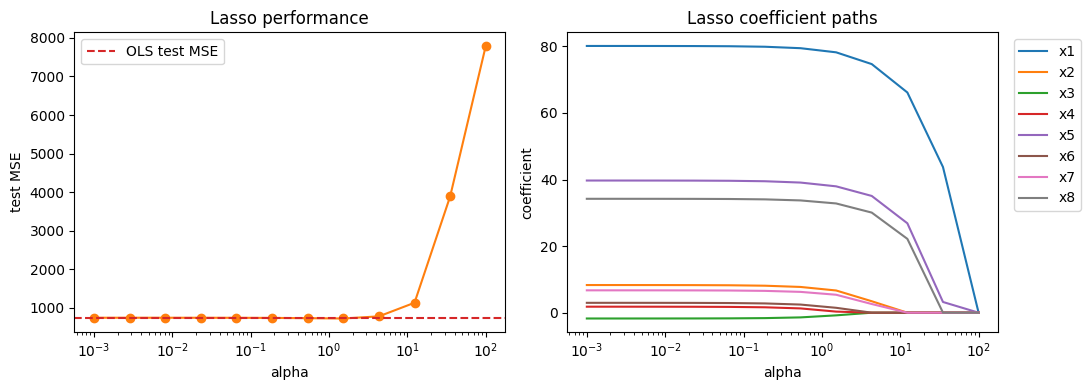

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(11, 4))
axes[0].plot(lasso_scores["alpha"], lasso_scores["test_mse"], marker="o", color="tab:orange")
axes[0].axhline(ols_results["test_mse"], color="tab:red", linestyle="--", label="OLS test MSE")
axes[0].set_xscale("log")
axes[0].set_xlabel("alpha")
axes[0].set_ylabel("test MSE")
axes[0].set_title("Lasso performance")
axes[0].legend()
for feature in feature_names:
    axes[1].plot(lasso_coefs.index, lasso_coefs[feature], label=feature)
axes[1].set_xscale("log")
axes[1].set_xlabel("alpha")
axes[1].set_ylabel("coefficient")
axes[1].set_title("Lasso coefficient paths")
axes[1].legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [24]:
elastic_scores, elastic_coefs = evaluate_model(ElasticNet, alphas, l1_ratio=0.5, max_iter=5000)
elastic_scores


,alpha,test_mse
0,0.001000,745.382652
1,0.002848,744.236992
2,0.008111,741.083042
3,0.023101,732.957122
4,0.065793,716.305098
5,0.187382,712.454480
6,0.533670,914.443601
7,1.519911,1917.846773
8,4.328761,4014.380567
9,12.328467,6098.423961


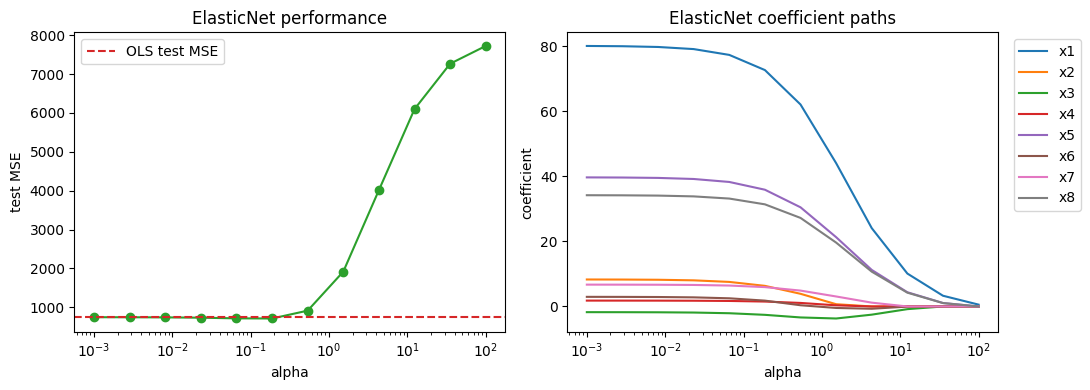

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(11, 4))
axes[0].plot(elastic_scores["alpha"], elastic_scores["test_mse"], marker="o", color="tab:green")
axes[0].axhline(ols_results["test_mse"], color="tab:red", linestyle="--", label="OLS test MSE")
axes[0].set_xscale("log")
axes[0].set_xlabel("alpha")
axes[0].set_ylabel("test MSE")
axes[0].set_title("ElasticNet performance")
axes[0].legend()
for feature in feature_names:
    axes[1].plot(elastic_coefs.index, elastic_coefs[feature], label=feature)
axes[1].set_xscale("log")
axes[1].set_xlabel("alpha")
axes[1].set_ylabel("coefficient")
axes[1].set_title("ElasticNet coefficient paths")
axes[1].legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


### Takeaways

- Ridge shrinks all coefficients smoothly and can reduce variance without forcing weights to zero.
- Lasso drives some weights exactly to zero for larger `alpha`, selecting a smaller feature set.
- ElasticNet balances both L1 and L2 penalties, often a good default when features are correlated.
- Comparing test MSE across `alpha` values highlights the bias-variance trade-off introduced by regularization.
